In [1]:
import numpy as np
import tensorflow as tf
from DeepAnt import DeepAnt
from WindowGen import WindowGenerator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from get_UCR_anomaly import get_UCR_anomaly

%matplotlib inline

2023-01-30 15:42:47.749891: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-30 15:42:47.952932: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-30 15:42:47.952976: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-30 15:42:48.763939: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

UCR_209_Fantasia 19000 [26970, 27270]


[]

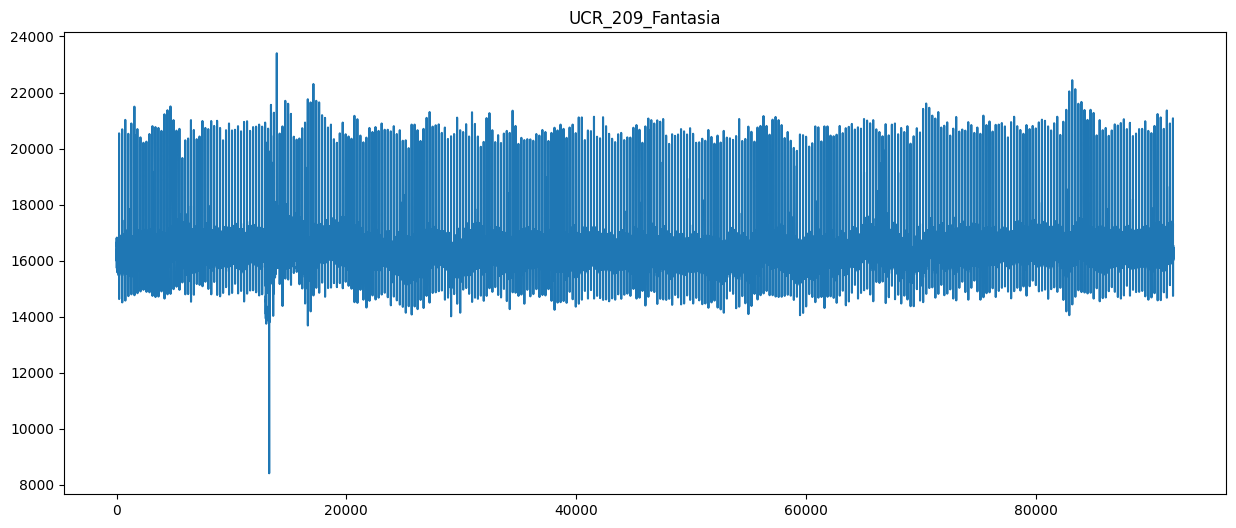

In [3]:
#df = pd.read_csv('data/TravelTime_451.csv', index_col = 'timestamp', parse_dates=['timestamp'])
path = '/home/emerson/data/UCR_anomaly_dataset/209_UCR_Anomaly_Fantasia_19000_26970_27270.txt'

#'/home/emerson/data/UCR_anomaly_dataset/204_UCR_Anomaly_CHARISfive_12412_15000_15070.txt'
#'/Users/Okano700/Documents/GitHub/metaFeaturesTS/data/UCR_Anomaly_FullData/182_UCR_Anomaly_qtdbSel1005V_4000_12400_12800.txt'


#'/Users/Okano700/Documents/GitHub/metaFeaturesTS/data/UCR_Anomaly_FullData/222_UCR_Anomaly_mit14046longtermecg_56123_91200_91700.txt'
#'/Users/Okano700/Documents/GitHub/metaFeaturesTS/data/UCR_Anomaly_FullData/152_UCR_Anomaly_PowerDemand1_9000_18485_18821.txt'
#'/Users/Okano700/Documents/GitHub/metaFeaturesTS/data/UCR_Anomaly_FullData/120_UCR_Anomaly_ECG2_15000_16000_16100.txt'


split_name = str(path).split('/')[-1]
split_name = str(split_name).split('.')[0]
name_aux = str(split_name).split('_')
ds_name = f"{name_aux[1]}_{name_aux[0]}_{name_aux[3]}"
m_v = int(name_aux[4])
an = [int(name_aux[5]), int(name_aux[6])]
print(ds_name, m_v, an)



df_1 = np.genfromtxt(path)
df = pd.DataFrame(df_1,columns=['value'])
df.plot(figsize = (15, 6), title = ds_name, legend = False);
start, end, m_v = get_UCR_anomaly(df, path)
#y_ = np.zeros(len(df))
#y_[an[0]:an[1]] =1
#df['anomaly'] = y_
plt.plot()

In [4]:
df

,value,anomaly
0,15768.0,0.0
1,16048.0,0.0
2,16096.0,0.0
3,15784.0,0.0
4,15816.0,0.0
...,...,...
91995,16480.0,0.0
91996,16208.0,0.0
91997,16072.0,0.0
91998,16208.0,0.0


In [5]:
from scipy.signal import periodogram
from math import floor
f, px = periodogram(np.array(df)[:,0], detrend='linear')
floor(1/f[np.argmax(px)] + 0.5)
n = 20
ind = np.argpartition(px, -n)[-n:]


print([floor(1/f[a] + 0.5) for a in px.argsort()[-n:][::-1]])
print([f[a] for a in px.argsort()[-n:][::-1]])

[92000, 4, 4, 4, 4, 30667, 4, 4, 266, 264, 267, 4, 4, 4, 265, 66, 38, 44, 23000, 8364]
[1.0869565217391305e-05, 0.23993478260869566, 0.23997826086956522, 0.23992391304347827, 0.23998913043478262, 3.260869565217392e-05, 0.24000000000000002, 0.23995652173913046, 0.0037608695652173916, 0.0037934782608695654, 0.0037500000000000003, 0.2399130434782609, 0.23978260869565218, 0.24001086956521742, 0.003771739130434783, 0.015173913043478262, 0.026510869565217393, 0.022717391304347828, 4.347826086956522e-05, 0.00011956521739130435]


In [27]:
w_l = 2*66
p_w = 1

In [28]:
ds = WindowGenerator(input_width= w_l, label_width= p_w, shift = 1, train_df = df['value'].loc[:m_v].to_frame(), test_df = df['value'].to_frame(), val_df = df['value'].loc[:m_v].to_frame())

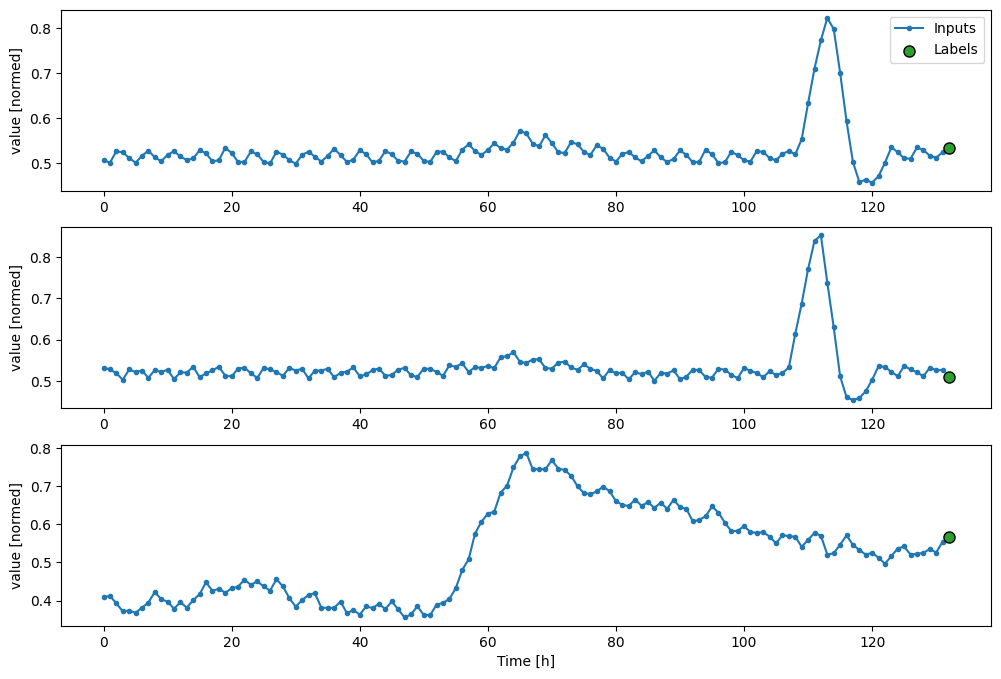

In [29]:
ds.plot(plot_col='value')

In [30]:
ds.make_dataset(df['value'].to_frame())

<MapDataset element_spec=(TensorSpec(shape=(None, 132, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>

In [31]:
DA = DeepAnt(w_l = w_l)

In [32]:
def compile_and_fit(model, window,MAX_EPOCHS = 30, patience=5):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
    checkpoint_filepath = 'tmp/checkpoint'

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping,model_checkpoint_callback], verbose = 0)
    return history

In [33]:
hist = compile_and_fit(DA, ds, patience =10, MAX_EPOCHS = 50)

DA.load_weights('tmp/checkpoint')

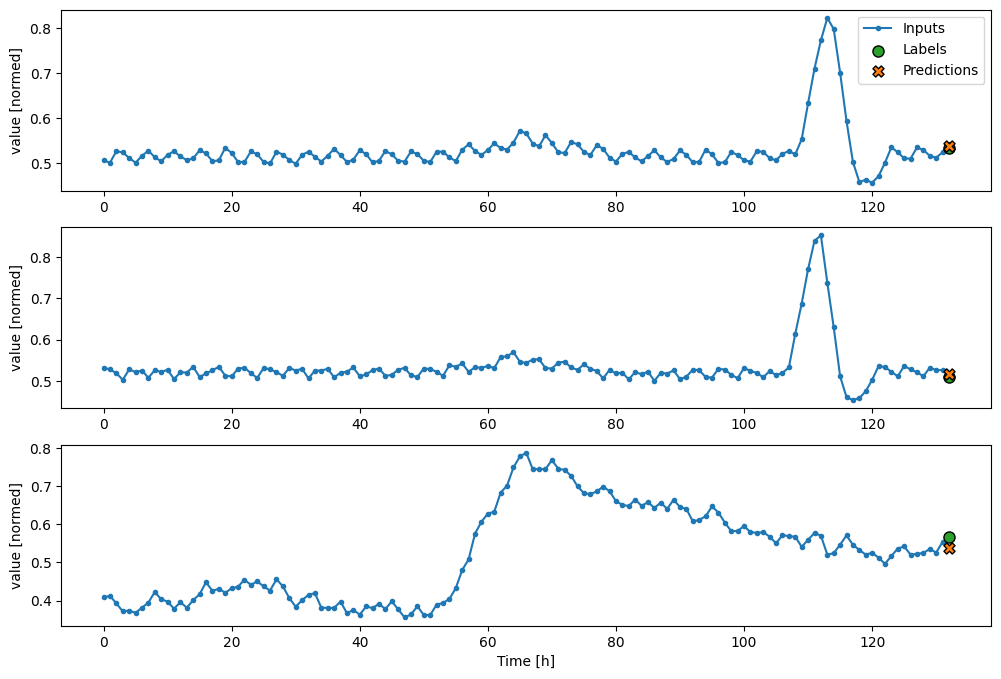

In [34]:
ds.plot(DA, plot_col='value')

In [35]:
a =ds.make_ds_pred(data = df['value'].to_frame())

In [36]:
#loss_ = []
#for X,y in a.as_numpy_iterator(): 
#    loss_.append(np.squeeze(np.abs(y- DA.predict(X))))

In [37]:
yhat, loss = DA.get_loss(a)
preds_losses = pd.Series(loss, index = np.arange(w_l,len(df)))

91868/91868 [==============================] - 136s 1ms/step


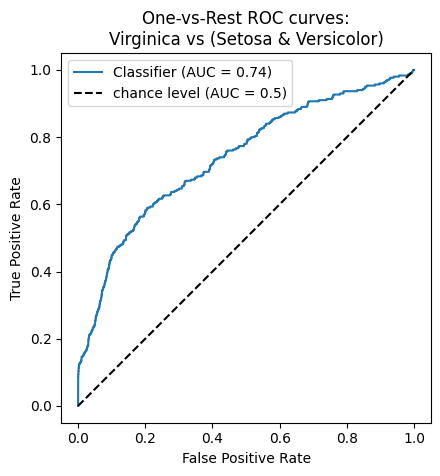

In [38]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, RocCurveDisplay
RocCurveDisplay.from_predictions(df['anomaly'].iloc[preds_losses.index.min():], preds_losses)
#plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
#display.plot()

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

In [39]:
def plot_predictions(preds, threshold, bins = 80):
    sns.displot(preds, bins = bins, kde = True, height = 8, aspect = 2)
    plt.axvline(x = threshold, color = 'r', linestyle = '--', label = 'Chosen Threshold')
    plt.title('Loss Distribution')
    plt.legend()

def loss_plot(preds, threshold):
    preds.plot(figsize = (15,8), title = 'Chosen Threshold', label = 'Loss')
    plt.axhline(y = threshold, color = 'r', linestyle = '--', label = 'Chosen Threshold')
    plt.legend()
    plt.show();

def ts_plot(df, preds, threshold, alg = 'DeepAnT', range = None):
    idx = preds.loc[lambda x: x > threshold].index
    plt.figure(figsize = (20,8))
    if range is not None:
        min, max = range
        df = df[min:max]
    plt.plot(df, label = '_nolegend_')
    plt.scatter(idx, df.loc[idx], color = 'red', label = 'Detected Anomalies by DeepAnt')
    plt.title('Detected Anomalies in Time Series')
    plt.legend()
    plt.show();

In [ ]:
THRESHOLD = 0.35
plot_predictions(preds_losses, THRESHOLD)

In [ ]:
loss_plot(preds_losses, 0.4)

In [ ]:
ts_plot(df['value'], preds_losses, 0.15)

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(yhat.reshape(-1,1))

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit_transform(df['value'].values.reshape(-1,1))

In [ ]:
np.array(df['value'].to_frame())

In [ ]:
idx = preds_losses.loc[lambda x: x > 0.5].index

In [ ]:
idx

In [ ]:
len(df)

In [ ]:
np.zeros(len(df))